In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # Data visualization
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA, NMF
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, confusion_matrix



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
!pip install klib

In [3]:
import klib

# Starship Titanic:

Here lies the entry into my first Kaggle competition, and also my final project for my supervised learning course. 
I will be trying various supervised learning methods from the sklearn library for classifying the data, and 
ultimately enter the final model for consideation in the competiton. 

In [4]:
# Lets start with getting the dataset entered into the system.
# Training set is complete, test set is X data only and will be used for submissions

train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submit = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

# Exploratory Data Analysis
Some basic EDA to start with.

In [5]:
# Next a quick peek at the datas shape and contents.
print(f'data Shape: {train.shape}')
print(f'data info: {train.info()}')
train.head()


data Shape: (8693, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
data info: None


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
print(f'Missing test: \n {test.isna().sum()}\n')
print(f'Missing Train: \n {train.isna().sum()}')

Missing test: 
 PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

Missing Train: 
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [7]:
# by the looks of it there are several categories that are not relevent to the classification, such as name and passenger ID. 
# I will keep them for now, and explore their corelation as we move on. Name might not be important by itself, however 
# if the names can show relations, it may help to determine who was left and who was transported by relationship to each other.
# ie. Compare names for same last name.
# I would also like to see if passenger ID is corelated with any other features.

print(train.info())
for c in train.columns[2:]:
    print(c, train[c].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
CryoSleep [False True nan]
Cabin ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination ['TRAPPIST-1e' 'PSO J318.5-22'

<Axes: title={'center': 'Feature-correlation (pearson)'}>

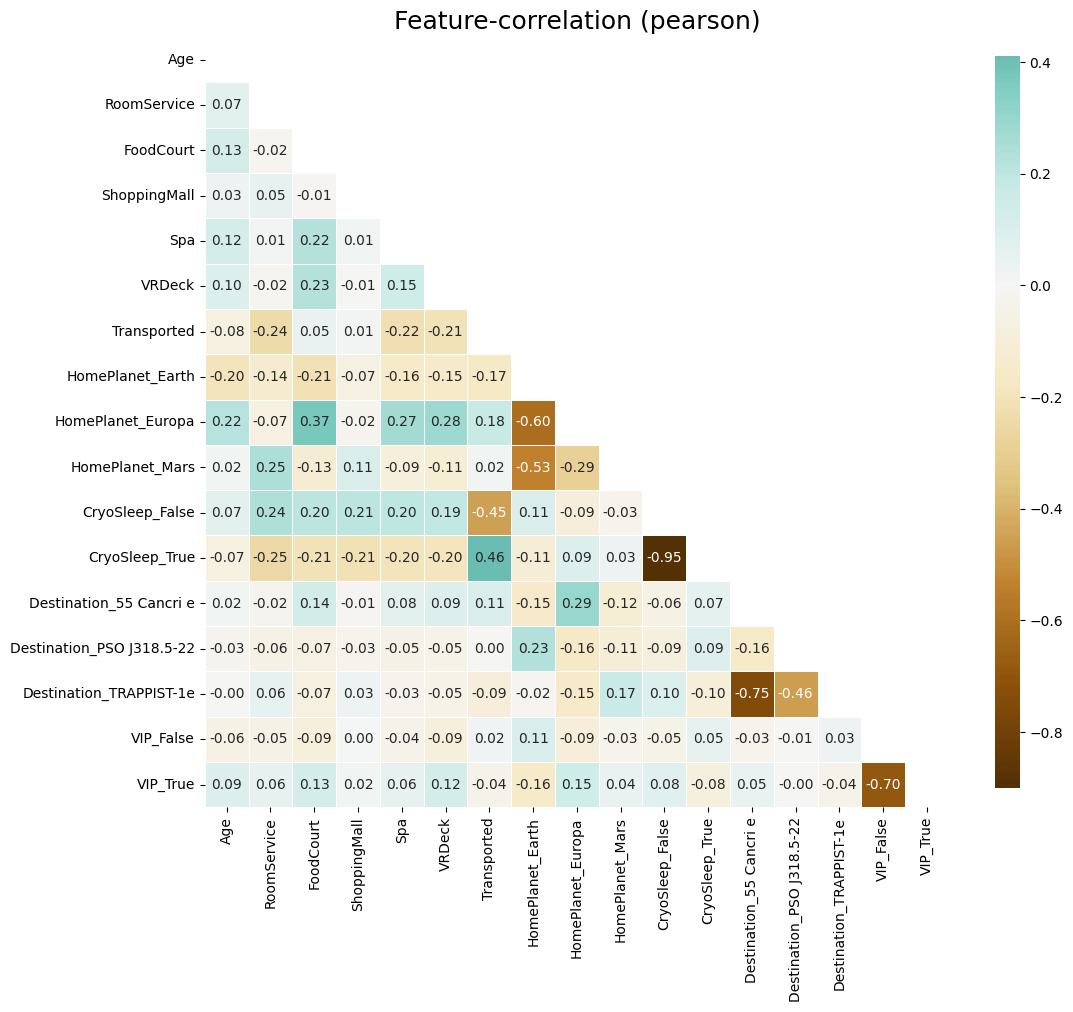

In [8]:
# Lets start with a correlation plot to see if any relationships stand out.
# Run the corr method to see if there are any correlations that stand out in the dataset.

dummy_data = pd.get_dummies(train.drop(columns=['PassengerId', 'Name', 'Cabin']))
klib.corr_plot(dummy_data)

# First Impressions
Some standouts among the crowd that correlate strongly with the target variable transported are:
first and foremost cryro_sleep, this seems to be a major determining factor with a correlation near .5
Next there a strong corelations in the .2 - .3 range for room service, spa, VR deck, home planet europa. 
These factors may indicate where on the ship a person was when the accident occured. 
passengers in cryosleep pods are more likely to survive vacuum of space when ship is damaged.
while passenger ID, cabin, and name don't seem to add any useful information on their own,
I can see several possibilities where they may in fact contribute a great deal in the final model. 
They will require parsing into new data such as family relations, cabin area or type, etc...

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

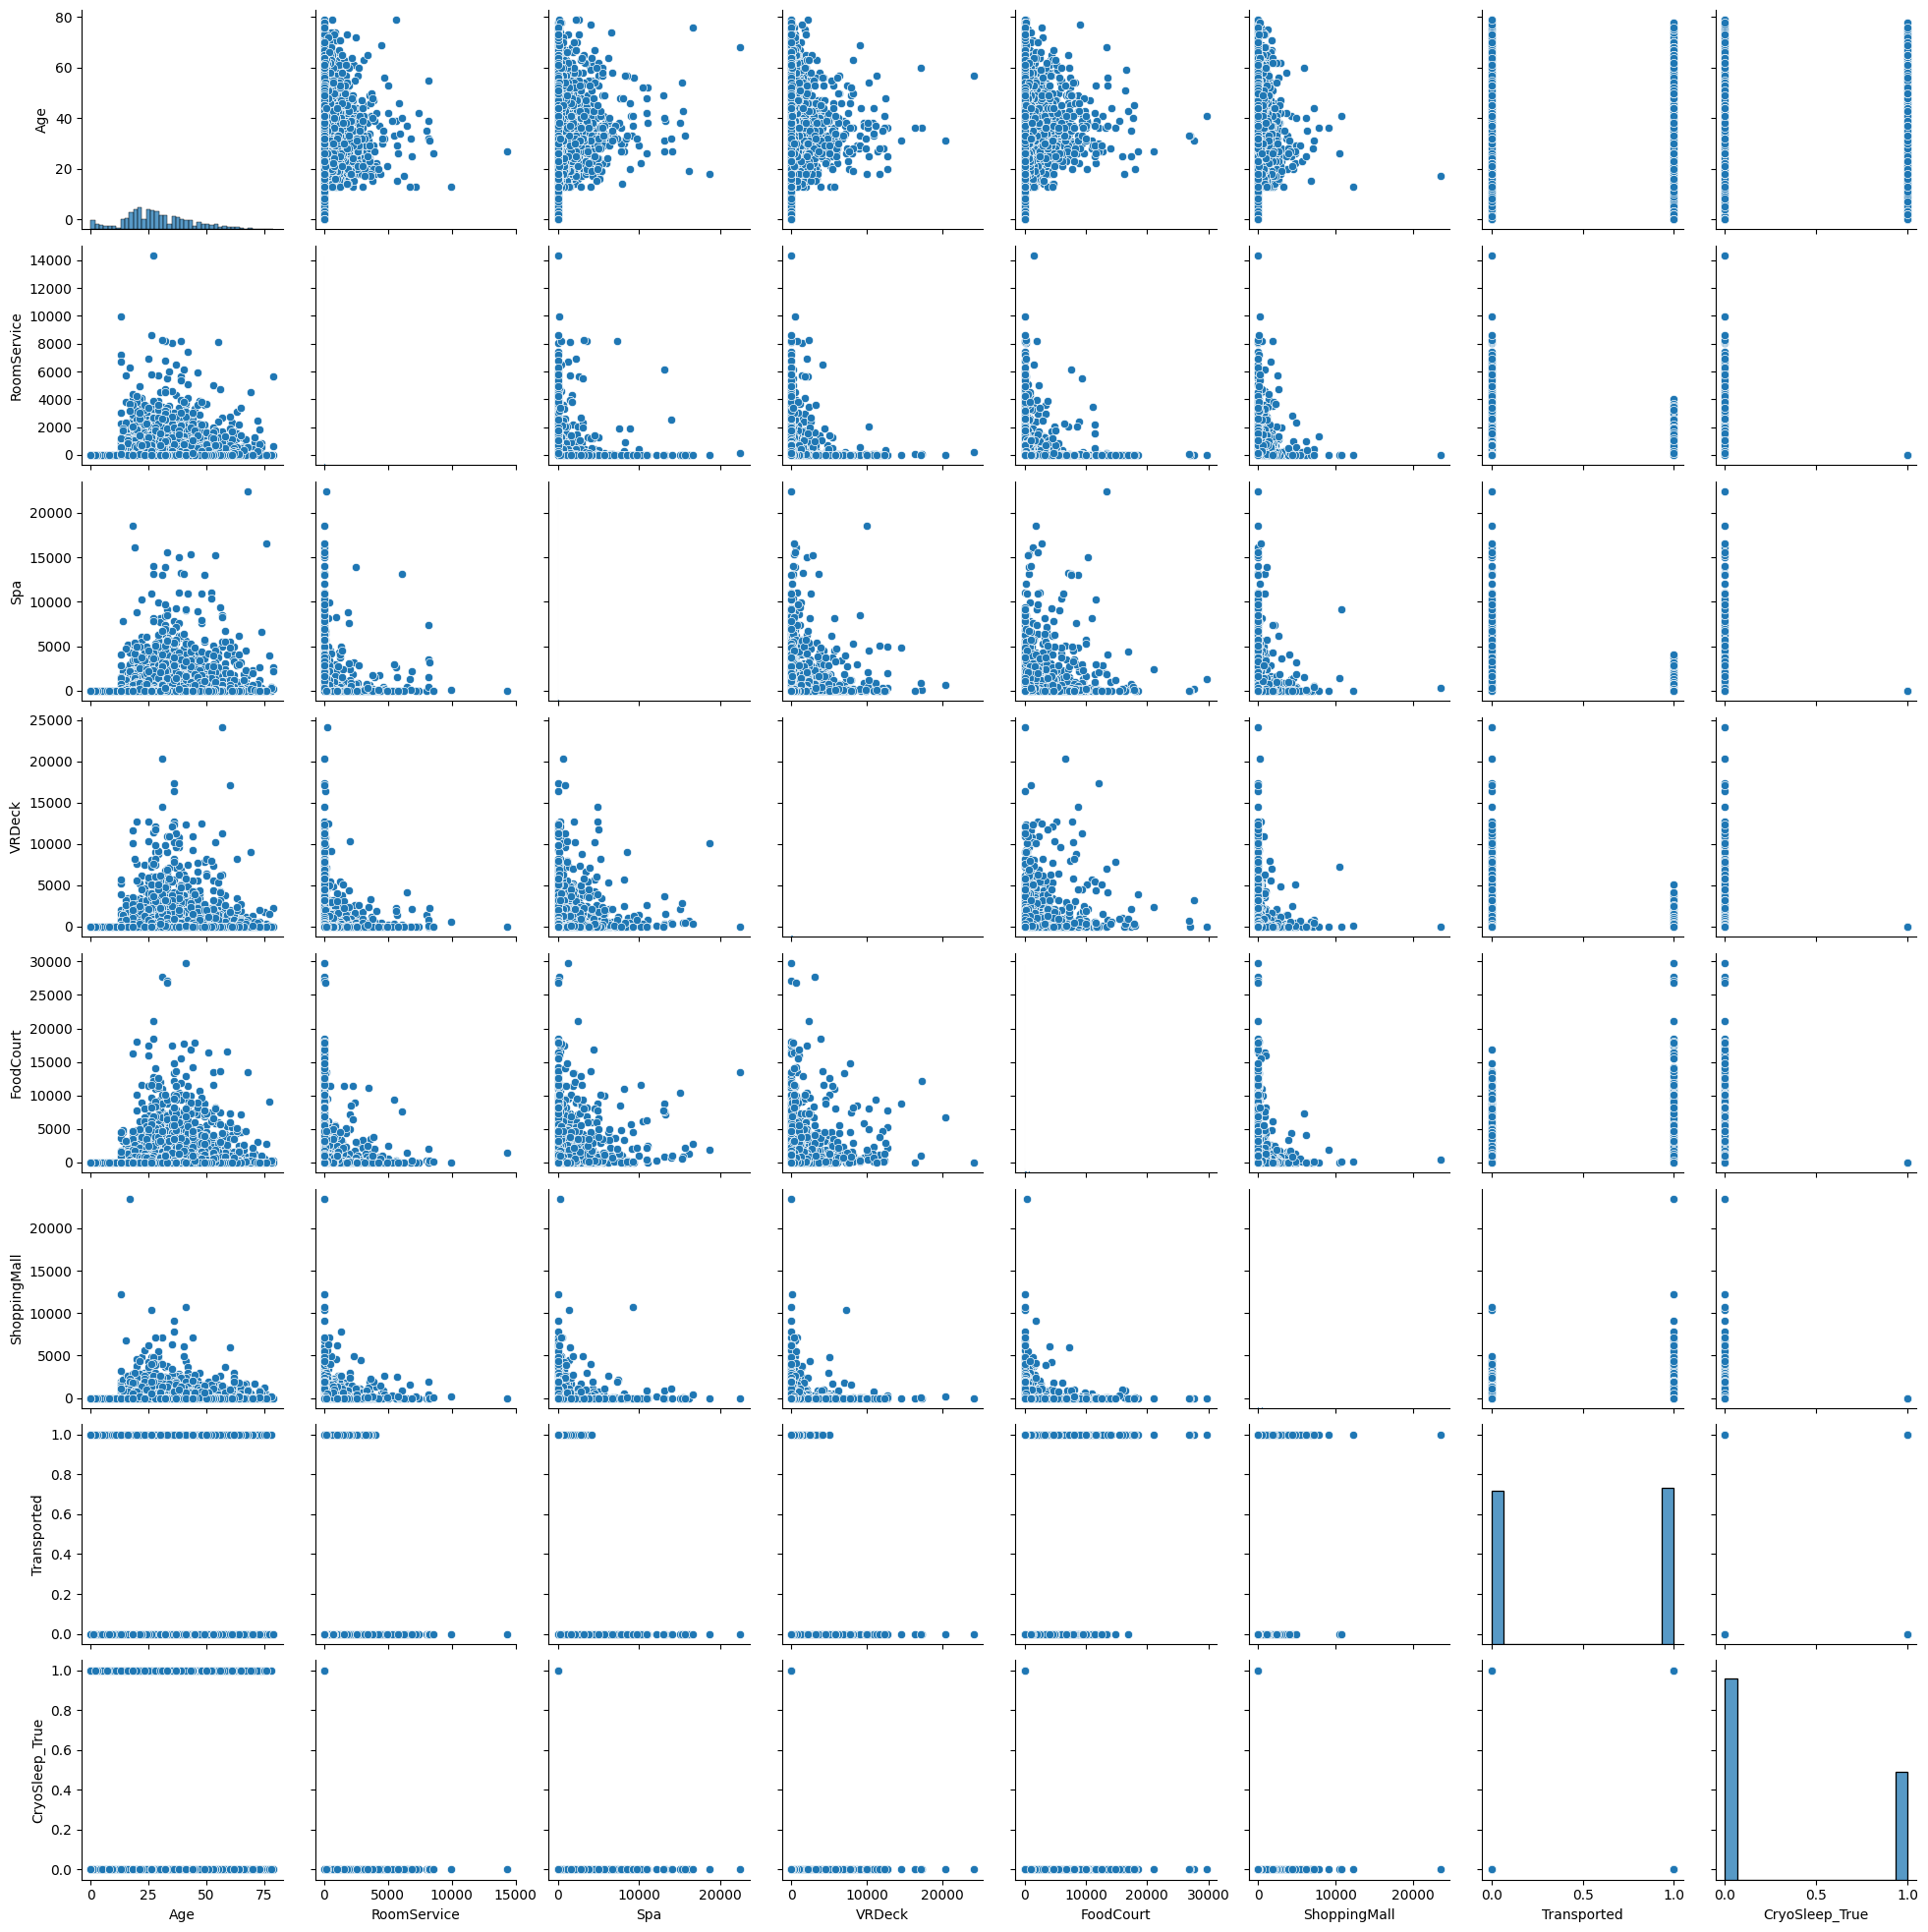

In [9]:
sns.pairplot(dummy_data[['Age','RoomService', 'Spa', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Transported', 'CryoSleep_True']])

# New insights
After running this pair plot I realized something that may be very helpful. One way to remove the nan from cryrosleep is to see if they spent any money on the mall or food service etc... If they did, cyrosleep is false, if they didn't cryrosleep is true.
also the inverse is true, and anyone in cryosleep, values for spending can be set to zero, and not in cryro sleep spending can be set to average for age group, as that seems to be the biggest correlation for spending. Other factors to consider, is corelation of VIP to cryo sleep as well. Sleeper might not chose VIP as that would be pretty useless when you are sleeping.  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: xlabel='VRDeck', ylabel='Density'>

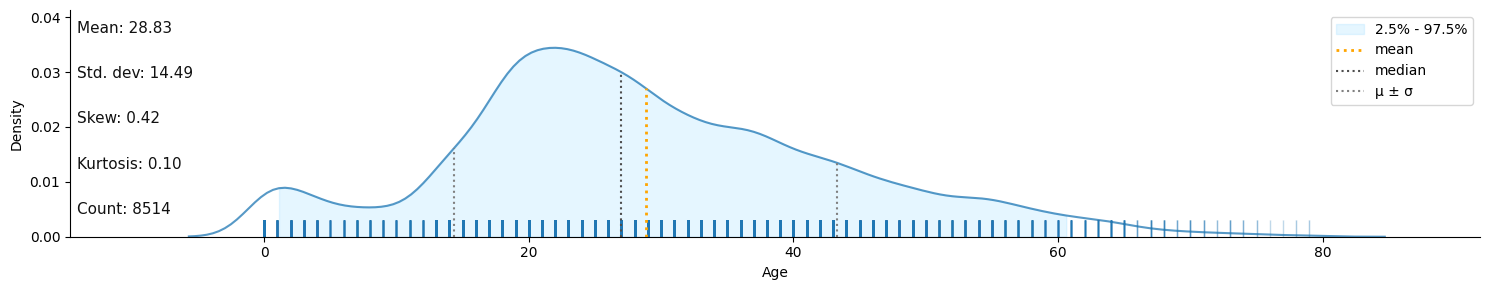

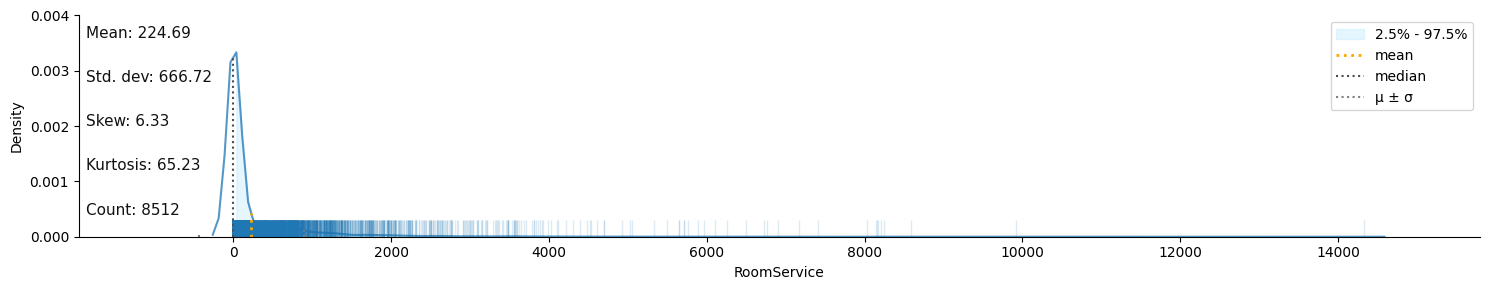

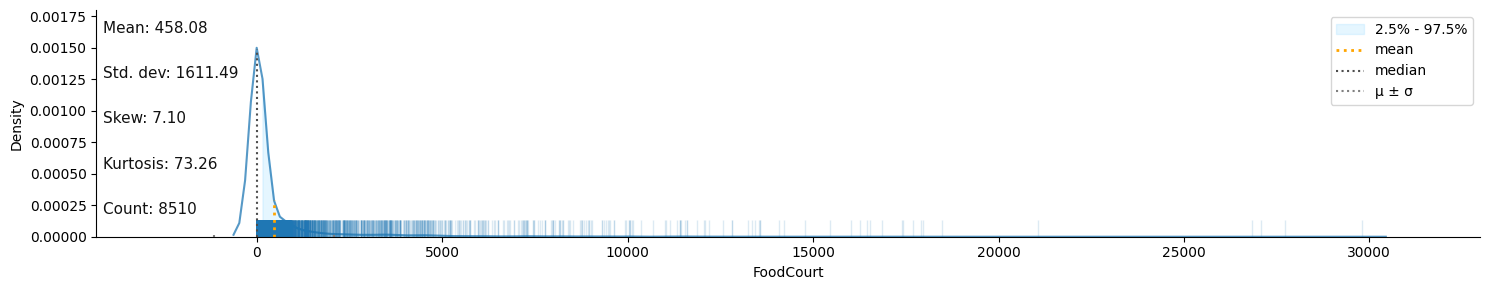

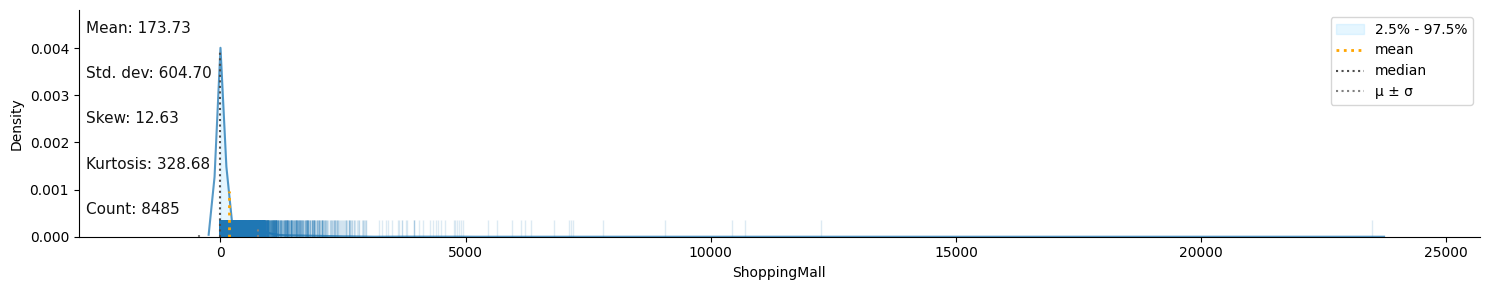

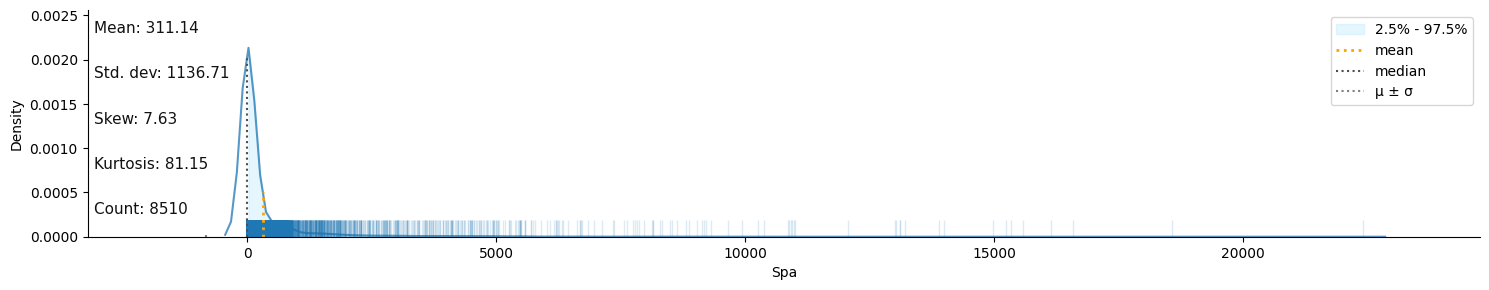

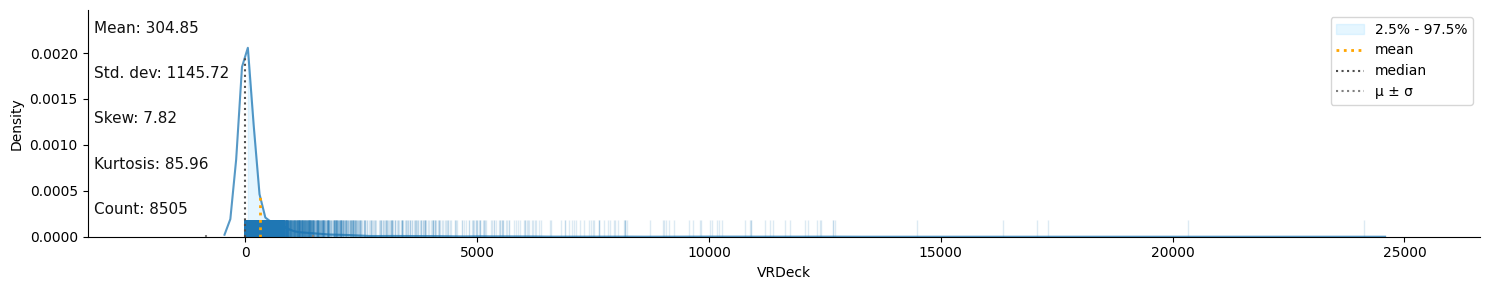

In [10]:
klib.dist_plot(dummy_data, showall=True)

In [11]:
# average age is about 30
# if spending 0 cryoSleep likely true. If spending cryoSleep = False.
# no one under 13 spends money
# Europa only A,B,C
# Europa and mars in D
# All in E
# Earth and mars in F
# Earth Only G
# Earth cryro cabins much more likely to not transport
# Europa cryro almost all transported.
# second number on passenger ID indicated which passenger they are in that room.  
# missing planet, look for other occupants by first part of pass ID, take same planet.
# No missing passenger numbers, should be easier to assign rooms.



# Data Cleaning
Now that we have some insight into how to replace some of the NAN values, lets go through and replace as much as we can with the logic given. Then we will get dummies (categorical truth table) for the categorical data.

In [12]:
def cleanData(dirty):
    data = copy.deepcopy(dirty)
    try:
        data = data.drop(columns=['Transported'])
    except:
        pass
    print(f'\nStarting NA:\n{data.isna().sum()}\n')
    data = data.drop(columns=['Name'])
    
    # start with anyone spending money not cryoSleeping
    money_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    spending = data[money_columns].sum(axis=1) > 0
    
    cry_missing = data['CryoSleep'].isna()
    age_missing = data['Age'].isna()
    
    old_age = data['Age'] > 12 
    data.loc[cry_missing & spending, 'CryoSleep'] = False
    data.loc[cry_missing & ~spending & old_age, 'CryoSleep'] = True
    data.loc[cry_missing & ~old_age, 'CryoSleep'] = False
    cryo_sleep = data['CryoSleep'] == True
    data.loc[age_missing & spending, 'Age'] = 25
    data.loc[age_missing & ~spending & ~cryo_sleep, 'Age'] = 5
    data['Age'] = data['Age'].fillna(20)
    

    
    # Move to Cryosleepers not spending any money
    
    cs_mask = data['CryoSleep'] == True
    data.loc[cs_mask, money_columns] = data.loc[cs_mask, money_columns].fillna(0)
    # next Age mask, no one under 13 spends any money
    age_mask = data['Age'] < 13
    data.loc[age_mask, money_columns] = data.loc[age_mask, money_columns].fillna(0)
    
    cleaned_passenger = [passenger.split('_') for passenger in data['PassengerId'].values]
    data['PassengerId'] = [p_id[0] for p_id in cleaned_passenger]
    data['PassengerNumber'] = [p_number[1] for p_number in cleaned_passenger]

    data['Cabin'] = data.groupby('PassengerId')['Cabin'].transform(lambda group: group.ffill().bfill())
    data['HomePlanet'] = data.groupby('PassengerId')['HomePlanet'].transform(lambda group: group.ffill().bfill())
    data['Destination'] = data.groupby('PassengerId')['Destination'].transform(lambda group: group.ffill().bfill())
    data['Cabin'] = data['Cabin'].fillna('G/0/P')

    cleaned_cabin = [cabin.split('/') for cabin in data['Cabin'].values]

    data['CLetter'] = [cabin[0] for cabin in cleaned_cabin]
    data['CNumber'] = [cabin[1] for cabin in cleaned_cabin]
    data['CSide'] = [cabin[2] for cabin in cleaned_cabin]
    data['VIP'] = data['VIP'].fillna(False)
    data.loc[data['CLetter'].isin(['A', 'B', 'C']) & data['HomePlanet'].isna(), 'HomePlanet'] = 'Europa'
    data.loc[data['CLetter'].isin(['G']) & data['HomePlanet'].isna(), 'HomePlanet'] = 'Earth'
    data['HomePlanet'] = data['HomePlanet'].fillna('Earth')
    data['Destination'] = data['Destination'].fillna('TRAPPIST-1e')

    
    data.loc[data['RoomService'].isna(), 'RoomService'] = data[money_columns].sum(axis=1) / 5
    data.loc[data['FoodCourt'].isna(), 'FoodCourt'] = data[money_columns].sum(axis=1) / 5
    data.loc[data['ShoppingMall'].isna(), 'ShoppingMall'] = data[money_columns].sum(axis=1) / 5
    data.loc[data['Spa'].isna(), 'Spa'] = data[money_columns].sum(axis=1) / 5
    data.loc[data['VRDeck'].isna(), 'VRDeck'] = data[money_columns].sum(axis=1) / 5

    data['CryoSleep'] = data['CryoSleep'] * 1
    data['VIP'] = data['VIP'] * 1

    cabin_letter_dummies = pd.get_dummies(data['CLetter'], dtype=int)
    cabin_side_dummies = pd.get_dummies(data['CSide'], dtype=int)
    home_dummies = pd.get_dummies(data['HomePlanet'], dtype=int)
    destination_dummies =  pd.get_dummies(data['Destination'], dtype=int)

    for feature in cabin_side_dummies:
        data[feature] = cabin_side_dummies[feature]
    
    for feature in cabin_letter_dummies:
        data[feature] = cabin_letter_dummies[feature]

    for feature in home_dummies:
        data[feature] = home_dummies[feature]
    
    for feature in destination_dummies:
        data[feature] = destination_dummies[feature]

    data = data.drop(columns=['HomePlanet', 'Cabin', 'Destination', 'CLetter', 'CSide', 'PassengerId', 'PassengerNumber', 'CNumber', 'VIP', 'Age'])

    
    
    print(f'\nNA values left:\n{data.isna().sum()}')
    return data


# Drop values for most accurate training.
By dropping the na values rather than using the guestimated values in training there is a small increase in accuracy.

In [13]:


def cleanDataDrop(dirty):
    data = copy.deepcopy(dirty)
    try:
        data = data.drop(columns=['Transported', 'Name'])
    except:
        pass
    print(f'\nStarting NA:\n{data.isna().sum()}\n')

    
    # Move to Cryosleepers not spending any money

    
    cleaned_passenger = [passenger.split('_') for passenger in data['PassengerId'].values]
    data['PassengerId'] = [p_id[0] for p_id in cleaned_passenger]
    data['PassengerNumber'] = [p_number[1] for p_number in cleaned_passenger]

    cleaned_cabin = [cabin.split('/') for cabin in data['Cabin'].values]

    data['CLetter'] = [cabin[0] for cabin in cleaned_cabin]
    data['CNumber'] = [cabin[1] for cabin in cleaned_cabin]
    data['CSide'] = [cabin[2] for cabin in cleaned_cabin]

    data['CryoSleep'] = data['CryoSleep'] * 1
    data['VIP'] = data['VIP'] * 1

    cabin_letter_dummies = pd.get_dummies(data['CLetter'], dtype=int)
    cabin_side_dummies = pd.get_dummies(data['CSide'], dtype=int)
    home_dummies = pd.get_dummies(data['HomePlanet'], dtype=int)
    destination_dummies =  pd.get_dummies(data['Destination'], dtype=int)

    for feature in cabin_side_dummies:
        data[feature] = cabin_side_dummies[feature]
    
    for feature in cabin_letter_dummies:
        data[feature] = cabin_letter_dummies[feature]

    for feature in home_dummies:
        data[feature] = home_dummies[feature]
    
    for feature in destination_dummies:
        data[feature] = destination_dummies[feature]
        
    data = data.drop(columns=['HomePlanet', 'Cabin', 'Destination', 'CLetter', 'CSide', 'PassengerId', 'PassengerNumber', 'CNumber', 'VIP', 'Age'])
    
    print(f'\nNA values left:\n{data.isna().sum()}')
    return data


In [14]:
d_train = train.dropna()
drop_train = cleanDataDrop(d_train)
drop_y = d_train['Transported'] * 1


Starting NA:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


NA values left:
CryoSleep        0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
P                0
S                0
A                0
B                0
C                0
D                0
E                0
F                0
G                0
T                0
Earth            0
Europa           0
Mars             0
55 Cancri e      0
PSO J318.5-22    0
TRAPPIST-1e      0
dtype: int64


In [15]:
final_test = cleanData(test)


Starting NA:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64



/tmp/ipykernel_318/2412120329.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Cabin'] = data.groupby('PassengerId')['Cabin'].transform(lambda group: group.ffill().bfill())
/tmp/ipykernel_318/2412120329.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['HomePlanet'] = data.groupby('PassengerId')['HomePlanet'].transform(lambda group: group.ffill().bfill())
/tmp/ipykernel_318/2412120329.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_obje


NA values left:
CryoSleep        0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
P                0
S                0
A                0
B                0
C                0
D                0
E                0
F                0
G                0
T                0
Earth            0
Europa           0
Mars             0
55 Cancri e      0
PSO J318.5-22    0
TRAPPIST-1e      0
dtype: int64


/tmp/ipykernel_318/2412120329.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['VIP'] = data['VIP'].fillna(False)


# Model building and training.
After trying several models individually I wrote up a function that consists of a dictionary of models and parameters and then uses grid search to optimize hyperparameters. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(drop_train, drop_y, test_size=0.2)

In [17]:
def superModelSearch(X_train, X_test, y_train, y_test): 
        model_grid = {'LogisticRegression':{'model': LogisticRegression(), 'parameters':{'C': [0.0001,0.001,0.01,0.1,1,10,100], 'penalty':['l2'], 'max_iter':[2000]}},
                    'KNeighborsClassifier':{'model': KNeighborsClassifier(), 'parameters':{'n_neighbors':[10, 12, 15, 18, 20, 25], 'weights':['uniform', 'distance']}},
                    'RandomForestClassifier':{'model': RandomForestClassifier(), 'parameters':{'n_estimators': [ 85, 100, 150],'max_depth': [None, 17, 18, 19, 20],'min_samples_split': [15, 18, 20]}},
                    'SVC':{'model': SVC(), 'parameters':{'C': [0.1, 1, 10, 50, 100],'kernel': ['rbf'],'gamma': ['scale', 'auto', 0.0001]}}
                     }
        
        results = []

        for model_name, parameters in model_grid.items():
                grid = GridSearchCV(estimator=parameters['model'], param_grid=parameters['parameters'], scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                y_hat = best_model.predict(X_test)
                acc = accuracy_score(y_test, y_hat)
                mse = mean_squared_error(y_test, y_hat)
                rmse = np.sqrt(mse)
                f1 = f1_score(y_test, y_hat, average='weighted')
                cm = confusion_matrix(y_test, y_hat)
                results.append({'Model': model_name, 'Best_Paramaters': grid.best_params_, 'Accuracy': acc, 'F1': f1, 'RMSE': rmse, 'Confusion_Matrix': cm})

        return pd.DataFrame(results)

# Feature Selection
After iterating through all features, adding them one by one, the most accurate is still the original set that I created just by adding in all the dummies from the categorical data, and dropping data I thought was relevant. So this feature was not useful, it was interseting, and informative. 

In [18]:
# a quick and dirty function to iterate through the features to see if they add to the sucess of the model.
#complete_list = ['CryoSleep', 'Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerNumber', 'CNumber', 'P', 'S', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Earth', 'Europa', 'Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']
#final_list = []
#previous_score = 0
#for feature in complete_list:
#    final_list.append(feature)
#    X_train, X_test, y_train, y_test = train_test_split(drop_train[final_list], drop_y, test_size=0.2)
#    #rfc = RandomForestClassifier(max_depth=19, min_samples_split=20, n_estimators=85)
#    #rfc.fit(X_train, y_train)
#    #score = cross_val_score(rfc, X_test, y_test)
#    score = superModelSearch(X_train, X_test, y_train, y_test)
#    if score < previous_score:
#        final_list.pop()
#    else:
#        previous_score = score
#    print(f'Score: {score} \n Final List: {final_list}')

In [19]:
results = superModelSearch(X_train, X_test, y_train, y_test)
print(results)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
                    Model                                    Best_Paramaters  \
0      LogisticRegression     {'C': 0.01, 'max_iter': 2000, 'penalty': 'l2'}   
1    KNeighborsClassifier          {'n_neighbors': 18, 'weights': 'uniform'}   
2  RandomForestClassifier  {'max_depth': 18, 'min_samples_split': 20, 'n_...   
3                     SVC      {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}   

   Accuracy        F1      RMSE          Confusion_Matrix  
0  0.802572  0.801344  0.444329   [[480, 184], [77, 581]]  
1  0.796520  0.796521  0.451087  [[527, 137], [132, 526]]  
2  0.802572  0.802471  0.444329  [[547, 117], [144, 514]]  
3  0.795008  0.793683  0.452761   [[474, 190], [81, 577]]  


the intial models ran up in the high 60s without any tuning, that is a logistic regeression, a random forest, and an SVC ran about 60-65% accuracy with default settings. 

In [20]:
print(results['Best_Paramaters'])
print(results['Best_Paramaters'][2])

0       {'C': 0.01, 'max_iter': 2000, 'penalty': 'l2'}
1            {'n_neighbors': 18, 'weights': 'uniform'}
2    {'max_depth': 18, 'min_samples_split': 20, 'n_...
3        {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Name: Best_Paramaters, dtype: object
{'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 100}


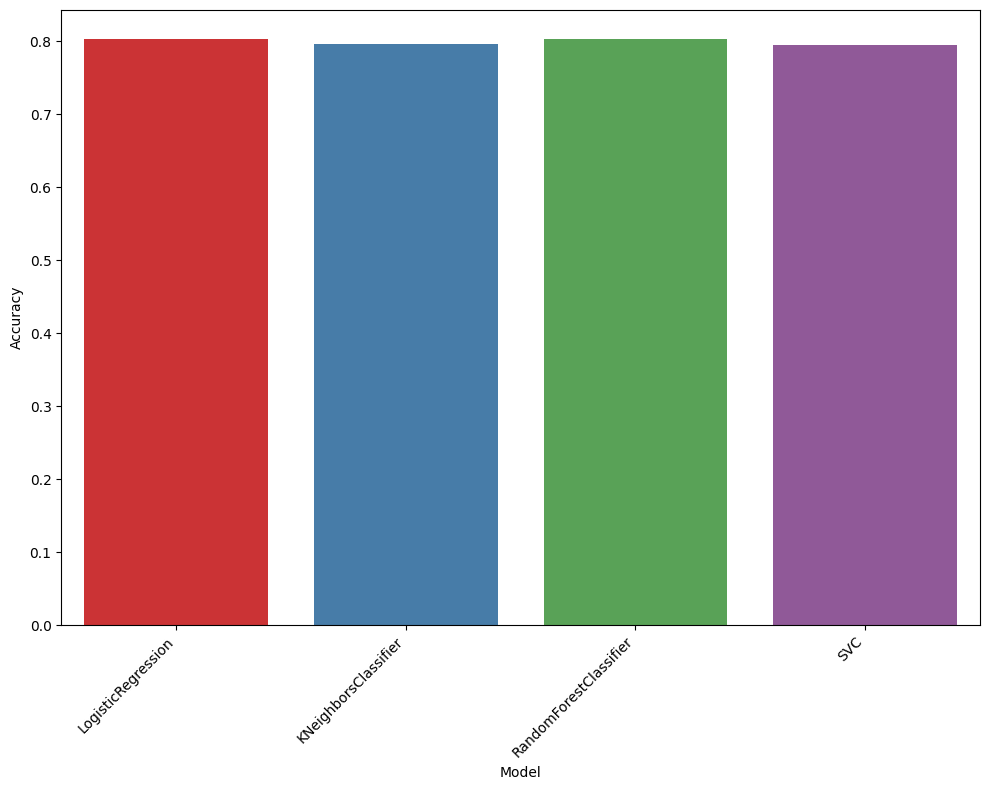

In [21]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Model', y='Accuracy', data=results, palette='Set1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Printing out the best parameters for all models and using the best settings to fit the model. 

# Testing out different preprocessing methods. 

In [22]:
ss = preprocessing.StandardScaler()
X_train_n = ss.fit_transform(X_train)
X_test_n = ss.fit_transform(X_test)
normal_test = ss.fit_transform(final_test)

In [23]:
rfc = RandomForestClassifier(max_depth=None, min_samples_split=20, n_estimators=150)
rfc.fit(X_train_n, y_train)
print(np.mean(cross_val_score(rfc, X_test_n, y_test)))
#final_predictions = rfc.predict(normal_test)
#submit['Transported'] = (final_predictions == 1)
#submit.to_csv('/kaggle/working/submission.csv', index=False)

0.7965294453973699


In [24]:
X_train_n = preprocessing.normalize(X_train)
X_test_n = preprocessing.normalize(X_test)
normal_test = preprocessing.normalize(final_test)

In [25]:
rfc = RandomForestClassifier(max_depth=None, min_samples_split=20, n_estimators=150)
rfc.fit(X_train_n, y_train)
print(np.mean(cross_val_score(rfc, X_test_n, y_test)))
#final_predictions = rfc.predict(normal_test)
#submit['Transported'] = (final_predictions == 1)
#submit.to_csv('/kaggle/working/submission.csv', index=False)

0.7957547169811321


In the end, the most accurate model did not use any standard preprocessors, though using them did not change the accuracy much. Instead the most accurate model only used the data that was cleaned using my own cleaning function.

In [26]:
rfc = RandomForestClassifier(max_depth=None, min_samples_split=15, n_estimators=85)
rfc.fit(X_train, y_train)
final_predictions = rfc.predict(final_test)
submit['Transported'] = (final_predictions == 1)
submit.to_csv('/kaggle/working/submission.csv', index=False)

In [27]:
print(np.mean(cross_val_score(rfc, X_train, y_train)))

0.7999629096069494


Cross val scoring is showing right in line with the resulting score, the model does not apear to be overfitting at all. 

# Conclusion -
I was hoping to crack the 80% accuracy barrier, but no matter how much time I spent on this porject I just couldn't ovecome that last 0.5%. I am happy with my progress, as my initial models were only hovering around the 60-65% range, and even models in the top 10 were only a few percent higher than that. In the end I did learn quite a bit from working on this project. Two major takeaways from this were: 1. Putting eyes on the data itself can tell a great deal when it comes to categorical data. 2. Dataframes can be a very powerful tool for data manipulation if you know how to use them.

# Depricated
Here lies the remnants from iteratting through ideas, and figuring things out. 

# ~Further data cleaning and anaylsis

In [28]:
"""
def cleanData(data):
    
    final_data = data
    temp_data = data.dropna()

    # Clean up the cabin data and replace NAN with most common values
    temp_cabin = [cabin.split('/') for cabin in temp_data['Cabin'].values]
    mc_cabin_letter = Counter([cabin[0] for cabin in temp_cabin]).most_common(1)[0][0]
    mc_cabin_side = Counter([cabin[2] for cabin in temp_cabin]).most_common(1)[0][0]
    cleaned_cabin = data['Cabin'].fillna(value=f'{mc_cabin_letter}/0/{mc_cabin_side}')
    final_data[['CabinLetter', 'CabinNumber', 'CabinSide']] = [cabin.split('/') for cabin in cleaned_cabin.values]
    
    final_data[['PassengerNumber', 'PassengerType']] = [passenger.split('_') for passenger in data['PassengerId'].values]
    
    mc_home_planet = Counter(data['HomePlanet']).most_common(1)[0][0]
    mc_destination = Counter(data['Destination']).most_common(1)[0][0]
    final_data['HomePlanet'] = data['HomePlanet'].fillna(value=f'{mc_home_planet}')
    final_data['Destination'] = data['Destination'].fillna(value=f'{mc_destination}')
    final_data['CryoSleep'] = data['CryoSleep'].fillna(value=Counter(data['CryoSleep']).most_common(1)[0][0])
    final_data['VIP'] = data['VIP'].fillna(value=Counter(data['VIP']).most_common(1)[0][0])

    #final_data['CryoSleep'] = data['CryoSleep'].fillna(value=False)
    #final_data['VIP'] = data['VIP'].fillna(value=False)

    final_data['RoomService'] = data['RoomService'].fillna(value=np.mean(data['RoomService']))
    final_data['Age'] = data['Age'].fillna(value=np.mean(data['Age']))
    final_data['FoodCourt'] = data['FoodCourt'].fillna(value=np.mean(data['FoodCourt']))
    final_data['ShoppingMall'] = data['ShoppingMall'].fillna(value=np.mean(data['ShoppingMall']))
    final_data['Spa'] = data['Spa'].fillna(value=np.mean(data['Spa']))
    final_data['VRDeck'] = data['VRDeck'].fillna(value=np.mean(data['VRDeck']))

    #final_data['RoomService'] = data['RoomService'].fillna(value=0)
    #final_data['Age'] = data['Age'].fillna(value=np.mean(data['Age']))
    #final_data['FoodCourt'] = data['FoodCourt'].fillna(value=0)
    #final_data['ShoppingMall'] = data['ShoppingMall'].fillna(value=0)
    #final_data['Spa'] = data['Spa'].fillna(value=0)
    #final_data['VRDeck'] = data['VRDeck'].fillna(value=0)
    
    final_data = final_data.drop(columns=['Cabin', 'PassengerId', 'Name'])
    final_data['CryoSleep'] = final_data['CryoSleep'] * 1
    final_data['VIP'] = final_data['VIP'] * 1
    dummies = pd.get_dummies(final_data[['HomePlanet', 'Destination', 'PassengerType', 'CabinLetter', 'CabinSide']], dtype=int)
    final_data = final_data.drop(columns=['HomePlanet', 'Destination', 'PassengerType', 'CabinSide', 'CabinNumber', 'CabinLetter', 'PassengerNumber'])
    final_data = pd.concat([final_data, dummies], axis=1 )
    
    return final_data

"""
    
    

"\ndef cleanData(data):\n    \n    final_data = data\n    temp_data = data.dropna()\n\n    # Clean up the cabin data and replace NAN with most common values\n    temp_cabin = [cabin.split('/') for cabin in temp_data['Cabin'].values]\n    mc_cabin_letter = Counter([cabin[0] for cabin in temp_cabin]).most_common(1)[0][0]\n    mc_cabin_side = Counter([cabin[2] for cabin in temp_cabin]).most_common(1)[0][0]\n    cleaned_cabin = data['Cabin'].fillna(value=f'{mc_cabin_letter}/0/{mc_cabin_side}')\n    final_data[['CabinLetter', 'CabinNumber', 'CabinSide']] = [cabin.split('/') for cabin in cleaned_cabin.values]\n    \n    final_data[['PassengerNumber', 'PassengerType']] = [passenger.split('_') for passenger in data['PassengerId'].values]\n    \n    mc_home_planet = Counter(data['HomePlanet']).most_common(1)[0][0]\n    mc_destination = Counter(data['Destination']).most_common(1)[0][0]\n    final_data['HomePlanet'] = data['HomePlanet'].fillna(value=f'{mc_home_planet}')\n    final_data['Destinati

# ~Simple Logisitc Regression Model
Just a quick Regression to determine how complex the model will need to be to accurately classify the data.

In [29]:
#lgrg = LogisticRegression(max_iter=100000)

In [30]:
#svc = SVC(gamma=.00001, C=1)
#svc.fit(final_train, final_y)
#print(svc.score(final_train, final_y))
#cross_val_score(svc, final_train, final_y)
#params = {'C':[0.1, 1, 2, 5, 10, 20, 50, 100, 1000], 'kernel':['rbf'], 'gamma':[.00001, .0001, .001]}
#grid = GridSearchCV(svc, param_grid=params, refit=True, verbose=3)
#grid.fit(final_train, final_y)
#print(grid.score(final_train, final_y))
#print(grid.best_estimator_)
#print(grid.best_score_)


In [31]:
#final_predictions = rfc.predict(final_test)
#submit['Transported'] = (final_predictions == 1)
#submit.to_csv('/kaggle/working/submission.csv', index=False)

In [32]:
#rfc = RandomForestClassifier(max_depth=7, max_features=20)
#rfc.fit(final_train, final_y)

In [33]:
#knn = KNeighborsClassifier(n_neighbors=3)
#knn.fit(final_train, final_y)
#print(knn.score(final_train, final_y))

In [34]:
#lgrg = LogisticRegression(max_iter=100000)
#lgrg.fit(final_train, final_y)
#preds = lgrg.predict(final_train)
#print(preds)
#acc = np.mean(preds == final_y)
#print(f'accuracy: {acc}')

In [35]:
# separate the data into a label name list, y (target), X (features, data)
#cleaned = dummy_data.dropna()
#X = cleaned.drop(columns='Transported')
#y = 1 * cleaned['Transported']
#for c in X.columns[2:]:
#    print(c, X[c].unique())

#print(X.info())
#X.head()
#X-train, X_test, y_train, y_test



In [36]:
#print(rfc.score(final_train, final_y))

In [37]:

#nmf = NMF(n_components=5, init='random', random_state=42, max_iter=1000)
#train_transform = nmf.fit_transform(X_train)
#test_transform = nmf.fit_transform(X_test)